In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# file  = "HS_front_RH50_PR0_PRRELAX86400_day0_500_all.dat"
file  = "HS_front_RH80_PR0_PRRELAX86400_with_w_all.dat"

ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_w_full_xyzt"])))
dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
test = np.zeros(u.shape)
print(test.shape)

<KeysViewHDF5 ['_types', 'grid_geopots_xyzt', 'grid_lnp_full_xyzt', 'grid_lnp_half_xyzt', 'grid_lnps_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_xyzt', 'grid_t_c_xyzt', 'grid_t_eq_xyzt', 'grid_tracers_c_xyz1t', 'grid_tracers_diff_xyz1t', 'grid_tracers_n_xyz1t', 'grid_tracers_p_xyz1t', 'grid_u_c_xyzt', 'grid_v_c_xyzt', 'grid_w_full_xyzt', 'grid_Δp_xyzt', 'spe_div_c_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_vor_c_xyzt']>
1.1106318184925956
(500, 20, 64, 128)


In [176]:
### to do omega
# first do virtial temperature
t  = dycore.getVar("grid_t_c_xyzt")
e  = dycore.getVar("grid_tracers_c_xyz1t")
p  = dycore.getVar("grid_p_full_xyzt")
ps  = dycore.getVar("grid_ps_xyzt")
omega  = dycore.getVar("grid_w_full_xyzt")

Rd = 287
g = 9.81
r = 0.622 * e / (p - e)
tv = t * (1 + 0.61 * r)

delta_h = Rd / g * tv * np.log(ps/p)
delta_h_mean = np.nanmean(delta_h, axis=(0,2,3))
print(delta_h.shape)
print(np.nanmax(Rd / g * tv))
h_all = 0
# omega = np.zeros(t.shape)
# for k in range(500):
#     for i in range(64):
#         for j in range(128):
#             h_all = 0
#             for z in range(20):
#                 h_all += (delta_h[k,z,i,j])
#                 omega[k,z,i,j] = -p[k,z,i,j] * w[k,z,i,j] / h_all
print(h_all)
print(omega.shape)

(500, 20, 64, 128)
9129.543445420923
0
(500, 20, 64, 128)


In [217]:
def plot_V_W_80(pr):
    file  = f"HS_front_RH80_PR0_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (100000 / p)**(Rd/cp)
    H = 6800
    p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = np.exp(-Z_all[:,i,:,:]/H) 
    omega  = dycore.getVar("grid_w_full_xyzt")
    w = - omega / rho_0_all / g
    ### do dz by dz = H * ln(ps/p)
    dz = np.zeros(20)
    for i in range(0,20):
        dz[i] = H * np.log(p0 /np.nanmean(p, axis=(0,2,3))[i])
    print(dz)
    print(delta_h_mean)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    height =  H * np.log(p0/np.nanmean(p, axis=(0,2,3)))
    for i in range(1,20-1):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / ((dz[i+1] - dz[i-1])) #((height[i+1] - height[i-1]))
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  / ((dz[1] - dz[0]))
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) / ((dz[-1] - dz[-2]))
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    for i in range(0,128):
        Vza[:,:,:,i]     = v[:,:,:,i] - np.nanmean(v, axis=(3))
        THETAza[:,:,:,i] = theta[:,:,:,i] - np.nanmean(theta, axis=(3))
        Wza[:,:,:,i]     = w[:,:,:,i] - np.nanmean(w, axis=(3))
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3) ### mean lon

    Wzm = np.nanmean(w, axis=3)
    # Vzm = np.nanmean(v, axis=3)
    
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    # phi[:,0] = np.nan
    # phi[:,-1] = np.nan
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,20-1):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) / ((dz[i+1] - dz[i-1]))
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) / ((dz[1] - dz[0]))
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / ((dz[-1] - dz[-2]))
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    ###############################
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(2,64-1-1):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / ((phi[:,i+1] - phi[:,i-1]))
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  ((phi[:,1]  - phi[:,0]))
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / ((phi[:,-1] - phi[:,-2]))
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi/acphi) 
    wTEM = wTEM1 + wTEM2
    ##################################################
    # for w
    psi_w1 = Wzmtm
    psi_w2 = Wzmtm
    
    # psi_w = np.full((20,64),Wzmtm)
    # print(psi_w - Wzmtm)
    # psi_w  = Wzmtm
    
    psi_w1[:,0] = 0
    for ilat in range(1,64):
        dlat = phi[:,ilat] - phi[:,ilat-1]    
        psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])
        
    psi_w2[:,-1] = 0    
    for jlat in range(1,64-1):
        ilat = 64 -1 - jlat
        dlat = phi[:,ilat] - phi[:,ilat+1]       
        psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])
    
    psi_w = 0.5*(psi_w1+psi_w2)

    return psi_w,psi_w1,psi_w1,vTEM,wTEM, wTEM1, wTEM2, vTEM1, vTEM2, VTHzmtm, rho_0, THETAz, VTHzmtm, THzmtm, vTEM_tempdz, wTEM_tempdphi, wTEM_temp, rho_0_all

[27185.00994887 17758.20829326 14200.12091566 11889.49401524
 10171.32754857  8802.11262713  7663.47319834  6688.71317652
  5836.48568328  5079.36775825  4398.22986715  3779.19373149
  3211.86937197  2688.2753691   2202.14721582  1748.47748161
  1323.20035566   922.96935528   544.99700706   186.93685383]
[23505.67139409 15335.7474849  12310.3788062  10425.92109521
  9145.50810164  8161.79957226  7358.70946139  6633.85753161
  5961.0430448   5325.72449175  4722.25614805  4142.81911754
  3588.36165605  3052.64101022  2538.25391942  2039.28213254
  1558.82210472  1092.34803026   643.36544128   209.42586696]


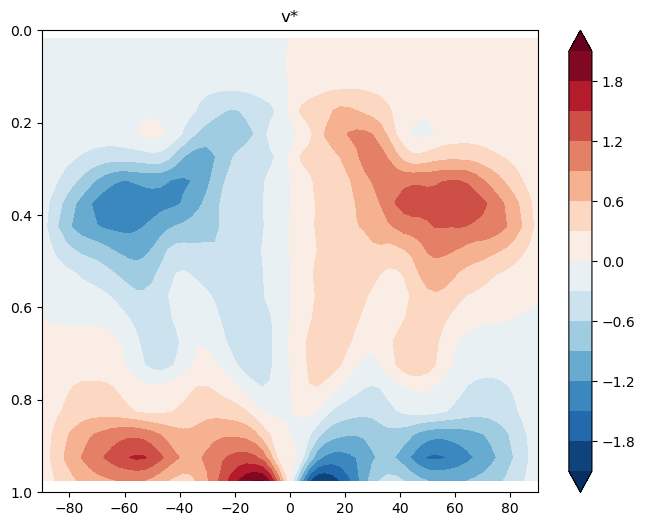

In [218]:
psi_w, psi_1, psi_2, vTEM, wTEM, wTEM1, wTEM2, vTEM1, vTEM2,VTHzmtm, rho_0, THETAz,VTHzmtm, THzmtm, vTEM_tempdz, wTEM_tempdphi, wTEM_temp, rho_0_all = plot_V_W_80(0)

# print((theta_result).shape)
plt.figure(figsize=(8,6))
y = np.linspace(-90,90,64)
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

plt.contourf(yy[:,:], sigma_mean2[:,:], vTEM[:,:], levels=np.linspace(-2.1,2.1,15), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("v*")
plt.show()


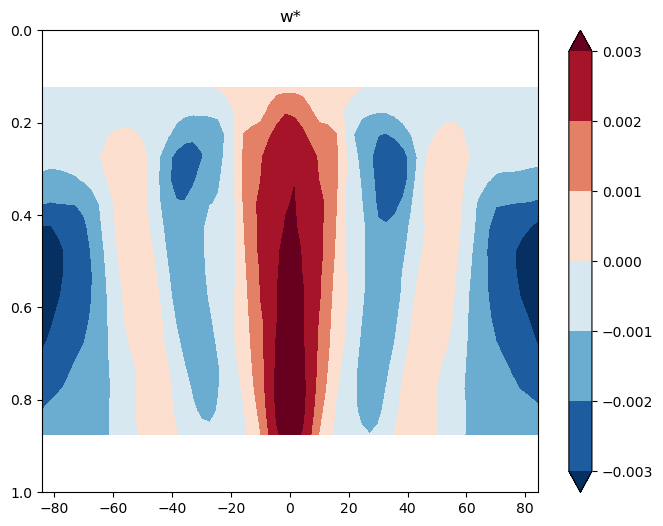

2950.363289254811 -2854.1772009437154


Text(0.5, 1.0, 'Residual mean meridional stream function ')

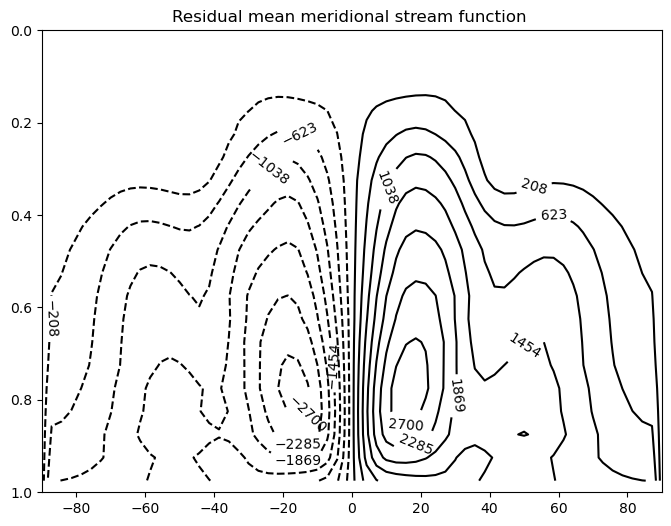

In [249]:
import cmaps
### poleward heat flux
a = 6.371e6
lat   = np.linspace(-90, 90, 64)
phi = np.tile(np.deg2rad(lat).reshape(1,64),(20,1)) # Get latitude in radians
# phi[:,0] = np.nan
# phi[:,-1] = np.nan
cphi  = np.cos(phi) 

acphi = a * cphi
###############################
w = -omega / rho_0_all / g
try_w = np.nanmean(w, axis=(0,3))
plt.figure(figsize=(8,6))
plt.contourf(yy[2:-2,2:-2], sigma_mean2[2:-2,2:-2],wTEM[2:-2,2:-2], cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("w*")
plt.show()
#################################
# cal psi and plot
# for w
psi_w1 = np.nanmean(w , axis=(0,3))
psi_w2 = np.nanmean(w , axis=(0,3))
# phi = np.tile(np.deg2rad(lat).reshape(1,64),(20,1)) # Get latitude in radians
# cphi  = np.cos(phi) 
# acphi = a * cphi

# print(phi[:,1])

psi_w1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]    
    psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 -1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]       
    psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])

psi_w = 0.5*(psi_w1+psi_w2)
#######################################
plt.figure(figsize=(8,6))
CS = plt.contour(yy,sigma_mean2, psi_w, levels=np.linspace(-2700,2700,14), colors='k')
print(np.nanmax(psi_w), np.nanmin(psi_w))
plt.clabel(CS)
plt.ylim([1,0])
plt.title("Residual mean meridional stream function ") #(kg $m^{-1}$ $s^{-1}$)

0.0036782736245060026 -0.003954321495133635


(1.0, 0.0)

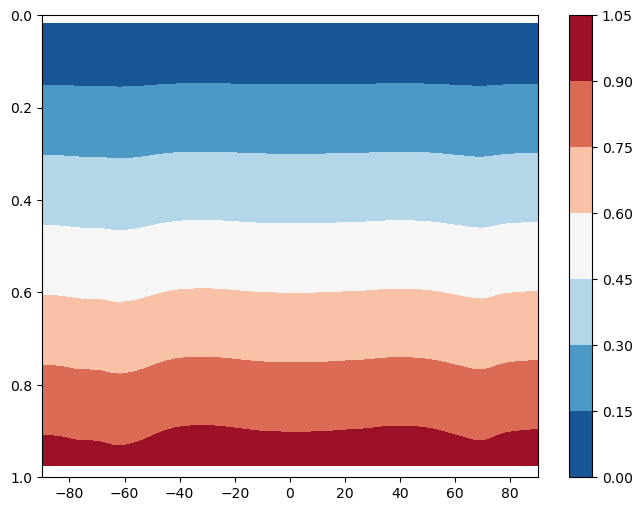

In [194]:
import cmaps
print(np.nanmax(wTEM2), np.nanmin(wTEM2))
plt.figure(figsize=(8,6))
CS = plt.contourf(yy,sigma_mean2,  (rho_0_all[0,:,:,1]), cmap=cmaps.MPL_RdBu_r)
plt.colorbar()
plt.ylim([1,0])
